### 0. Packages

In [66]:
import pandas as pd 
import numpy as np 
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
import os
import json
import geopandas as gpd
import matplotlib as mpl

import fasttext 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
import math
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import mannwhitneyu


# 1. Data cleaning and manipulation

## 1.1 Clean CMU dataset and filter horror movies

In [67]:
CMU_headers = ['Weekipedia_ID', 'Freebase_ID', 'Name', 'Release_date', 'Revenue', 'Runtime', 'Language', 'Countries', 'Genres']
CMU = pd.read_csv('data/MovieSummaries/movie.metadata.tsv', sep='\t', names=CMU_headers)

In [68]:
CMU['Release_year'] = CMU['Release_date'].astype(str).str.extract(r'(\d{4})')
CMU['Release_year'] = pd.to_numeric(CMU['Release_year'])

In [69]:
def extract_words(column):
    return column.apply(ast.literal_eval).apply(lambda x: list(x.values()))

cleaning_columns = ['Language', 'Genres', 'Countries']

for column_name in cleaning_columns:
    CMU[column_name+"_clean"] = extract_words(CMU[column_name])

def clean_language(language_string):
    return re.sub(" Language", "", language_string)

CMU.Language_clean = CMU.Language_clean.apply(lambda lang_list: list(map(clean_language, lang_list)))

isHorrorMovie = CMU['Genres_clean'].apply(lambda l: 'Horror' in l)
horror_df = CMU[isHorrorMovie]

In [70]:
CMU = CMU.drop(['Release_date', 'Language', 'Countries', 'Genres'], axis=1)

In [71]:
CMU_horror_df = CMU[CMU['Genres_clean'].apply(lambda l: 'Horror' in l)]

CMU_horror_df.shape

(5280, 9)

## 1.2 Clean additional horror movies dataset

In [72]:
horror_df = pd.read_csv('data/horror_movies.csv')

In [73]:
horror_df['Release_year'] = horror_df['release_date'].astype(str).str.extract(r'(\d{4})')
horror_df['Release_year'] = pd.to_numeric(horror_df['Release_year'])
horror_df = horror_df.drop(['original_title', 'poster_path', 'status', 'adult', 'backdrop_path', 'collection', 'release_date'], axis=1)

horror_df.shape

(32540, 14)

In [74]:
horror_df['genre_names'] = horror_df['genre_names'].str.split(',')

## 1.3 Merging the two datasets 

In [75]:
Horror_movies = pd.merge(CMU_horror_df, horror_df, left_on='Name',right_on='title', how='outer')

In [76]:
Horror_movies['Name'] = Horror_movies['Name'].combine_first(Horror_movies['title'])
Horror_movies['Release_year'] = Horror_movies['Release_year_x'].combine_first(Horror_movies['Release_year_y'])
Horror_movies['Runtime'] = Horror_movies['Runtime'].combine_first(Horror_movies['runtime'])
Horror_movies['Revenue'] = Horror_movies['Revenue'].combine_first(Horror_movies['revenue'])
Horror_movies['Genres'] = Horror_movies['Genres_clean'].combine_first(Horror_movies['genre_names'])

Horror_movies = Horror_movies.drop(['title', 'Release_year_x', 'Release_year_y', 'runtime', 'revenue', 'Genres_clean', 'genre_names'], axis=1)

In [77]:
Horror_movies['ID'] = Horror_movies.index + 1 
Horror_movies = Horror_movies.drop('id', axis=1)

## 1.4 Creating a text file with all summaries

In [78]:
CMU_plot_summaries = pd.read_csv('data/HorrorMovieSummaries.txt', sep='\t', header=None, names=['Weekipedia_ID', 'summary'])

In [79]:
merged_df = Horror_movies.copy()

In [80]:
# Ensure that both 'wiki_id' columns are of the same type
CMU_plot_summaries['Weekipedia_ID'] = CMU_plot_summaries['Weekipedia_ID'].astype(str)
merged_df['Weekipedia_ID'] = merged_df['Weekipedia_ID'].astype(str)

# Merge on 'wiki_id' to get the summaries in merged_df
merged_df = pd.merge(merged_df, CMU_plot_summaries, on='Weekipedia_ID', how='left')

In [81]:
merged_df['Summary'] = merged_df['overview'].combine_first(merged_df['summary'])

In [82]:
# Define the output file path
output_file = 'data/Summaries.txt'

# Write summaries to the output file
with open(output_file, 'w') as f:
    for _, row in merged_df.iterrows():
        # Write each line in the format: new ID followed by the summary
        f.write(f"{row['ID']}\t{row['Summary']}\n")

In [83]:
# Define the output file path
output_file = 'data/Taglines.txt'

# Write taglines to the output file, checking for non-NaN values
with open(output_file, 'w') as f:
    for _, row in merged_df.iterrows():
        # Check if 'tagline' is not NaN
        if pd.notna(row['tagline']):
            # Write each line in the format: new ID followed by the tagline
            f.write(f"{row['ID']}\t{row['tagline']}\n")

In [84]:
Horror_movies = Horror_movies.drop(['overview', 'tagline'], axis=1)

## 1.5 Get the cleaned data

In [85]:
Horror_movies.to_csv('data/Horror_Movies_Clean.csv')

In [86]:
# preparing data for historical analysis 
df_hist=merged_df.copy()
df_hist['Summary'] = df_hist['Summary'].fillna('') # replace NaN by empty string
df_hist['Release_year'] = df_hist['Release_year'].fillna(0).astype(int) 
df_hist['Release_year'] = pd.to_datetime(df_hist['Release_year'], format='%Y', errors='coerce')
df_hist = df_hist[df_hist['Release_year'] >= pd.to_datetime('1960', format='%Y')]

In [87]:
print(CMU[CMU['Release_year']==1010.0])
#should be 2010 and not 1010
CMU.loc[CMU['Release_year'] == CMU['Release_year'].min(), 'Release_year'] = 2010


CMU.rename(columns={'Weekipedia_ID': 'Wikipedia movie ID'}, inplace=True)
Horror_movies.rename(columns={'Weekipedia_ID': 'Wikipedia movie ID'}, inplace=True)

       Weekipedia_ID Freebase_ID            Name     Revenue  Runtime  \
62836       29666067  /m/0fphzrf  Hunting Season  12160978.0    140.0   

       Release_year      Language_clean  \
62836        1010.0  [Turkish, English]   

                                    Genres_clean Countries_clean  
62836  [Crime Fiction, Mystery, Drama, Thriller]        [Turkey]  


## 1.6 Trigger data

In [88]:
triggers = pd.read_csv('data/EVERY_trigger_movies.csv')
triggers.fillna(0, inplace = True)
triggers = triggers.apply(lambda col: col.astype(int) if col.dtype in ['float64', 'float32'] else col)
triggers = triggers.replace({1: True, 0: False})

merged = pd.merge(Horror_movies, triggers, left_on = 'Name', right_on = 'Movie')
merged = merged.dropna(subset=['Date'])

merged['Date'] = merged['Date'].astype(int)

/var/folders/53/kq0p4pc90m72m3_dzlskph3w0000gn/T/ipykernel_18163/3803901082.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triggers = triggers.replace({1: True, 0: False})


In [89]:
print('Number of movies in horror dataset :', len(Horror_movies))
print('Number of movies in trigger dataset :', len(triggers))
print('Number of common movies :',len(merged))

Number of movies in horror dataset : 34955
Number of movies in trigger dataset : 49803
Number of common movies : 10226


## 2.6 Historical

The goal of this part is to study the influence of historical events on the horror movie industry. Various topic will be analyzed.

For each of the topics that will be studied, we are going to ask chat-GPT for a list of simple and single word related to the topic. An average vector will represent the topic. We will iterate over every movies of the datatset to estimate the similarity between the topic and the summaries of the horror movies. Based on a threshold, we will determine if a movie contains or not a specific topic in its summary. A plot of the evolution of the occurence of the topic-related movies over the years will be plotted. We are going to ask chat-gpt to give use the years for which some worldwide events took place with regard of this topic.

The change in the occurence of the topic related movies of these years will tested statistically and evaluated with a significative value. We will discuss the accuracy of the method and the results.

BEWARE: If you run the code on your laptop, the textual analysis might not correspond to what you see due to the variability of the training of the model. If you want the comments to be coherent, I would advice not to run but just to read on the jupyter notebook.

The following function are used to evaluate the similarity between a subject (represented by some keywords) and the summaries form the data frame.

In [90]:
# Calculates the average vector for a list of keywords, according to the model previously trained
def get_average_vector(keywords, model):
    vectors = [model.get_word_vector(word) for word in keywords if word in model] # extracts the vector of each word of the list, from the model
    if vectors:
        return np.mean(vectors, axis=0) # return vector with mean of all vectors
    else:
        return np.zeros(model.get_dimension())


# Calculates a cosine similarity score between a summary and a vector
def calculate_similarity(summary, subject_vector, model):
    tokens = summary.split() # slip the string into a list of substrings
    summary_vectors = [model.get_word_vector(word) for word in tokens if word in model] # extracts the vector of each word of the list, fromm the model
    if not summary_vectors:
        return 0
    summary_vector = np.mean(summary_vectors, axis=0)
    return cosine_similarity([summary_vector], [subject_vector])[0][0] 

In [91]:
# Write summaries in a txt file to generate a model
with open("Summaries_without_ID.txt", 'w') as f:
    for _, row in df_hist.iterrows():
        # Write each line in the format: new ID followed by the summary
        f.write(f"\t{row['Summary']}\n")

# Train the model without any labeled data
model = fasttext.train_unsupervised("Summaries_without_ID.txt")

Read 1M words
Number of words:  18165
Number of labels: 0
Progress: 100.0% words/sec/thread:   70343 lr:  0.000000 avg.loss:  2.334546 ETA:   0h 0m 0s


### Consideration for the use of chat-GPT

The search in keywords in chat-GPT was done the following way: 

" This is my code:

[code of the application of the function `calculate_similarity`]
[code of the `model` training]
[code of function `analyze_similarity`]
[code of the application of the function `analyze_similarity`]

By using this function, I'm looking to search for a see if there is a dependance between a lexical field of a subject found in the summary of some horror movies and some historical events linked to this subject that have taken place in the world. To do so, I evaluate the p_value from the Mann-Whitney U Test to see if the difference in cosine similarity is significative.

What I need you to do is to create a python list of at least 40 single (1 word only) words (called '[insert subject]_keywords') that are in the lexical field of the of the following subject: petrol crisis. Some of the word should have the same root as the subject and some not. This corresponds to the variable 'subject_keywords' in my code

After I want you to give me a python dictionary (called '[insert subject]_events') that give the main year and name of events linked to the subject given beforehand. Give 3 to 7 events, between 1960 and 2020, according to the importance of them. Give them in a chronological order. This corresponds to the variable 'subject_events' in my code'. "

Consideration:
- We have chosen not to search for historical events before 1960, because there wasn't enough movie available so a small change might be significative when it shouldn't, and after 2020 because there was not enough time in year to search for a change after an event.
- We have chosen to take at least 40 word because the test that where run on list of a size of 15 words weren't as conclusive as the one with a larger size.
- We have chosen to add as input the code (function and model training) that we use because we though that it might help the AI to gather so keyword that are more significant.
- The range of number historical events was determined as optimal when running the code with different values and showed that having too much events overload the graph and include too many non meanningfull events.

In [92]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import mannwhitneyu

# Function that plots the evolution of the similarity between a subject's lexical field 
# and horror movies summaries. It also statistically evaluates the significance for historical events

def analyze_similarity(df, similarity_col, events, threshold):

    # Create a binary column for the presence/absence of the subject according to threshold
    df[f'Contains_{similarity_col}'] = df[similarity_col].apply(lambda x: 1 if x > threshold else 0)
    presence_subject = df.groupby(df["Release_year"])[[f'Contains_{similarity_col}']].sum()
    
    # Total number of horror movies per year
    total_movies_per_year = df.groupby(df["Release_year"])['Summary'].count()
    
    # Proportion of horror movies which summary is influenced by the subject's lexical fields per year
    proportion_subject = presence_subject[f'Contains_{similarity_col}'] / total_movies_per_year

    years_of_interest = list(events.keys())
    results = {}

    # Loop over each year of interest
    for year in years_of_interest:
        
        # Range of years before and after the year of interest
        before_range = [year-1, year, year + 1]
        after_range = [year + 1, year + 2, year + 3, year + 4, year + 5]

        # Filter dataframe
        before_counts = df[df['Release_year'].dt.year.isin(before_range)].groupby(df['Release_year'].dt.year)[f'Contains_{similarity_col}'].sum()
        after_counts = df[df['Release_year'].dt.year.isin(after_range)].groupby(df['Release_year'].dt.year)[f'Contains_{similarity_col}'].sum()

        # Years of minimum and maximum occurrences in range
        min_year = before_counts.idxmin() if not before_counts.empty else None
        max_year = after_counts.idxmax() if not after_counts.empty else None

        # Make sure max_year is not smaller than min_year to avoid decrease in number of movies
        if min_year >= max_year:
            max_year += 1
            if min_year == max_year:
                max_year += 1
                
        if min_year is not None and max_year is not None:
            # Filter dataframe for the adequate min and max year
            min_year_data = df[df['Release_year'].dt.year == min_year][f'Contains_{similarity_col}']
            max_year_data = df[df['Release_year'].dt.year == max_year][f'Contains_{similarity_col}']

            if len(min_year_data) > 0 and len(max_year_data) > 0:
                # Mann-Whitney U test
                stat, p_value = mannwhitneyu(min_year_data, max_year_data)
                
                # Assign result values
                results[year] = {
                    "statistic": stat,
                    "p_value": p_value,
                    "min_year": min_year,
                    "max_year": max_year,
                    "min_year_count": before_counts[min_year],
                    "max_year_count": after_counts[max_year]
                }
               
    # Transform into dataframe
    df_stats = pd.DataFrame(results).T
    
    # Filter significant events
    df_stats['Significant'] = df_stats['p_value'] < 0.05


    ### Plot
    plt.style.use('dark_background')
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Title with custom text formatting
    ax1.set_title(f"Evolution of the similarity between lexical field of {similarity_col.split('_')[0].lower()} and horror movies summaries (Threshold: {threshold:.2f})")

    # Total horror movie
    ax1.plot(total_movies_per_year.index, total_movies_per_year.values, color='#ff7100', label='Total horror movies per year')
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Count", color='#ff7100')
    ax1.tick_params(axis='y', labelcolor='#ff7100')
    ax1.legend(loc='upper left')
    ax1.set_ylim(0, total_movies_per_year.max() * 1.6)

    # Proportion of movies which summaries are influenced by subject lexical field
    ax2 = ax1.twinx()
    ax2.spines['right'].set_position(('axes', 1.0))
    ax2.plot(proportion_subject.index, proportion_subject * 100, color='#ae03ff', linestyle='-', label=f'{similarity_col.split("_")[0].title()} influenced horror movies summary')
    ax2.set_ylabel("Proportion (%)", color='#ae03ff')
    ax2.tick_params(axis='y', labelcolor='#ae03ff')
    ax2.legend(loc='upper right')
    ax2.set_ylim(0, proportion_subject.max() * 100 * 2)

    # Labels of events 
    last_plotted_year = None
    y_positions = [total_movies_per_year.max() * 1.1, total_movies_per_year.max() * 1] 

    for year, event in events.items():
        p_value = df_stats.loc[year, "p_value"] if year in df_stats.index else None
        if p_value is not None:

            # Condition on color
            if p_value < 0.05:
                color = '#008000'
            elif 0.05 <= p_value < 0.10:
                color = '#f1c232'
            else:
                color = '#ff007f'
                
            label_text = f'{event}\n {year} (p={p_value:.3f})'

            # Condition to avoid overlapping the text
            if last_plotted_year and abs(year - last_plotted_year) < 5:
                y_position = y_positions[1]
            else:
                y_position = y_positions[0]

            # Vertical line
            ax1.axvline(x=pd.to_datetime(str(year)), color='grey', linestyle='--', linewidth=1)
            
            # Text
            ax1.text(
                pd.to_datetime(str(year)), 
                y_position, 
                label_text,
                color=color, fontsize=10, ha='center', va='bottom', rotation=45
            )
            
            last_plotted_year = year
            
    plt.tight_layout()
    plt.show()

## Terrorism

In the following part, we are going to focus on the occurrance of terrorism-related word in the summaries of the horror data frame.

In [93]:
# List of keywords related to terrorism, generated by chat-GPT
terrorism_keywords = [
    "terrorism", "terrorist", "terror", "extremism", "extremist", 
    "radicalism", "radical", "bombing", "explosion", "hijacking", 
    "hostage", "violence", "insurgency", "militant", "jihad", 
    "jihadist", "suicide", "martyr", "detonate", "detonation", 
    "attack", "assassination", "threat", "plot", "cell", 
    "sabotage", "warfare", "guerrilla", "intimidation", 
    "fear", "panic", "fundamentalism", "al-Qaeda", "ISIS", 
    "radicalization", "extremism", "counterterrorism", "militia", 
    "revolutionary", "sectarian", "violence", "caliphate"
]

# Generate subject vector
terrorism_vector = get_average_vector(terrorism_keywords, model)

# Apply similarity check to each summary
df_hist['Terrorism_similarity'] = df_hist['Summary'].apply(lambda x: calculate_similarity(x, terrorism_vector, model))

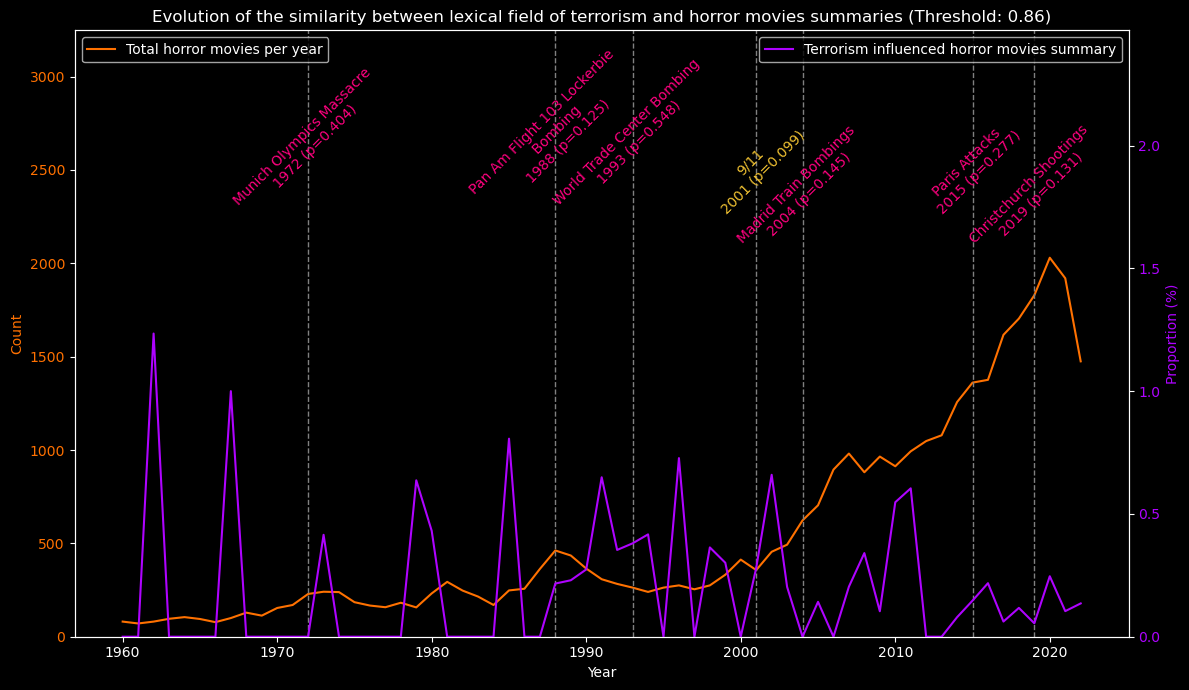

In [94]:
# Define the dictionary of historical events
terrorism_events = {
    1972: "Munich Olympics Massacre",
    1988: "Pan Am Flight 103 Lockerbie \n Bombing",
    1993: "World Trade Center Bombing",
    2001: "9/11",
    2004: "Madrid Train Bombings",
    2015: "Paris Attacks",
    2019: "Christchurch Shootings"
}

# Call the function
analyze_similarity(df_hist, similarity_col='Terrorism_similarity', events=terrorism_events, threshold=0.86)

For a threshold of 0.86, there are no events are statistically significant. Nevertheless, the event that we would expect to be significative is described by a p_value of 0.99, which is the lowest one among all the terrorism related events. It can be observed that each event presents a peak in the proportion of horror movies that show a higher similarity than the threshold, with the terrorism lexical field, the year after the event. Terrorism related events don't seem to influence drasticly the word used in a summary of the horror movies. 

### Pandemics & Epidemics

In [95]:
# List of keywords related to flu, generated by chat-GPT
flu_keywords = [
    "flu", "influenza", "virus", "pandemic", "epidemic", "outbreak", 
    "fever", "cough", "sneeze", "contagion", "contagious", "vaccine", 
    "vaccination", "quarantine", "isolation", "immunity", "symptom", 
    "pathogen", "infection", "infectious", "hygiene", "sanitation", 
    "pandemics", "seasonal", "transmission", "mutation", "swine", 
    "avian", "respiratory", "illness", "treatment", "medication", 
    "public", "health", "prevention", "spread", "diagnosis", "therapy", 
    "pharmaceutical", "recovery"
]

# Generate subject vector
flu_vector = get_average_vector(flu_keywords, model)

# Apply similarity check to each summary
df_hist['Flu_similarity'] = df_hist['Summary'].apply(lambda x: calculate_similarity(x, flu_vector, model))

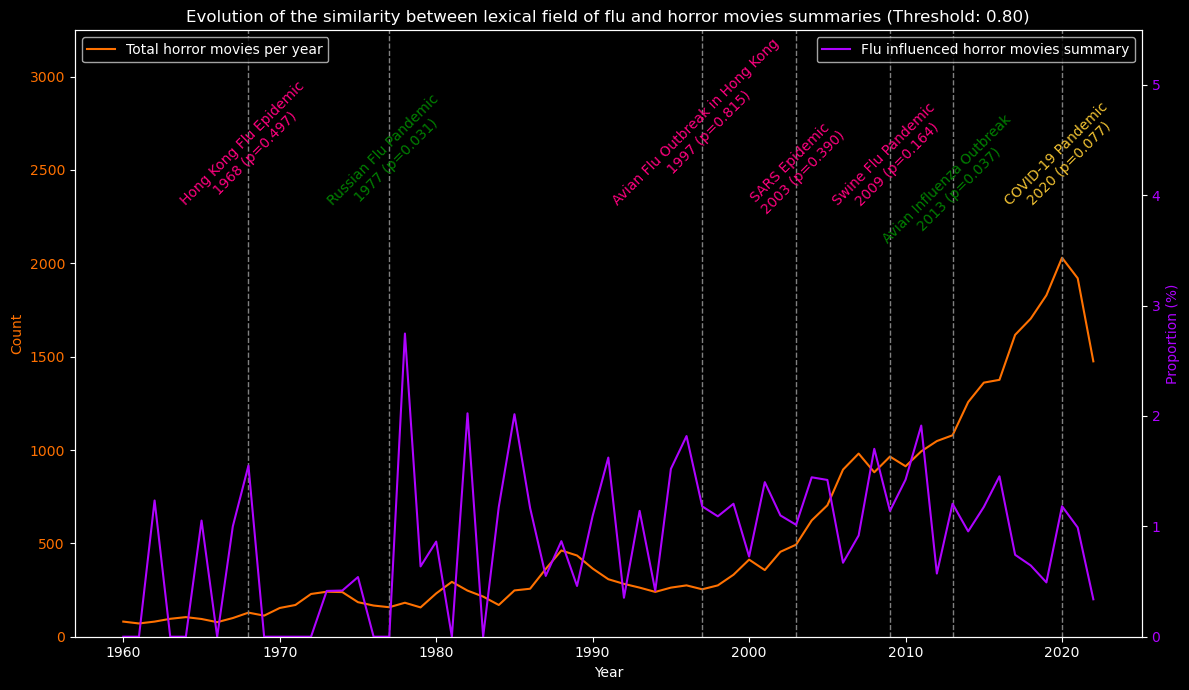

In [96]:
# Flu-related events
flu_events = {
    1968: "Hong Kong Flu Epidemic",
    1977: "Russian Flu Pandemic",
    1997: "Avian Flu Outbreak in Hong Kong",
    2003: "SARS Epidemic",
    2009: "Swine Flu Pandemic",
    2013: "Avian Influenza Outbreak",
    2020: "COVID-19 Pandemic"
}

# Call the function
analyze_similarity(df_hist, similarity_col='Flu_similarity', events=flu_events, threshold=0.80)

For a threshold of 0.80, there is only one significative year at 5% which corresponds to the Swine flu pandemic in 2009. This flu outbreak is the third recent flu pandemic involving the H1N1 virus. The number of cases including asymptomatic and mild cases could be 700 million to 1.4 billion people, more or less 11% to 21% of the global population. Note that the other pandemic involving this virus, the Russian flu from 1977, that mostly affected a population younger than 25, present a p_value that is significant only at 10%. This is also the case for the avian flu in 2013 and the Covid 19 pandemic from 2020. We would have expected the COVID 19 pandemic to be a significative year since it is the second deadliest pandemic since 1960. Nevertheless, our dataframe stops in 2023 so the time period tested for this events is smaller than for the others. Note that the deadliest pandemic, the HIV/AIDS pandemic, was not represented on the plot because it has not stopped spreading since 1960s, which could explain the occasional peaks over time. 

### Petrol crisis

In [97]:
# List of keywords related to petrol crisis, generated by chat-GPT
petrol_keywords = [
    "oil", "fuel", "energy", "gasoline", "crude", "refinery", 
    "embargo", "scarcity", "supply", "demand", "prices", "OPEC", 
    "market", "blackout", "shortage", "pipeline", "tar", "reserve", 
    "drilling", "exploration", "geopolitics", "cartel", "inflation", 
    "stockpiles", "consumption", "power", "transportation", "diesel", 
    "gas", "alternative", "subsidy", "export", "import", "global", "economy", 
    "competition", "recession", "climate", "carbon", "sustainability", 
    "tax", "fossil", "crisis"
]

petrol_vector = get_average_vector(petrol_keywords, model)

# Apply similarity check to each summary
df_hist['Petrol_similarity'] = df_hist['Summary'].apply(lambda x: calculate_similarity(x, petrol_vector, model))

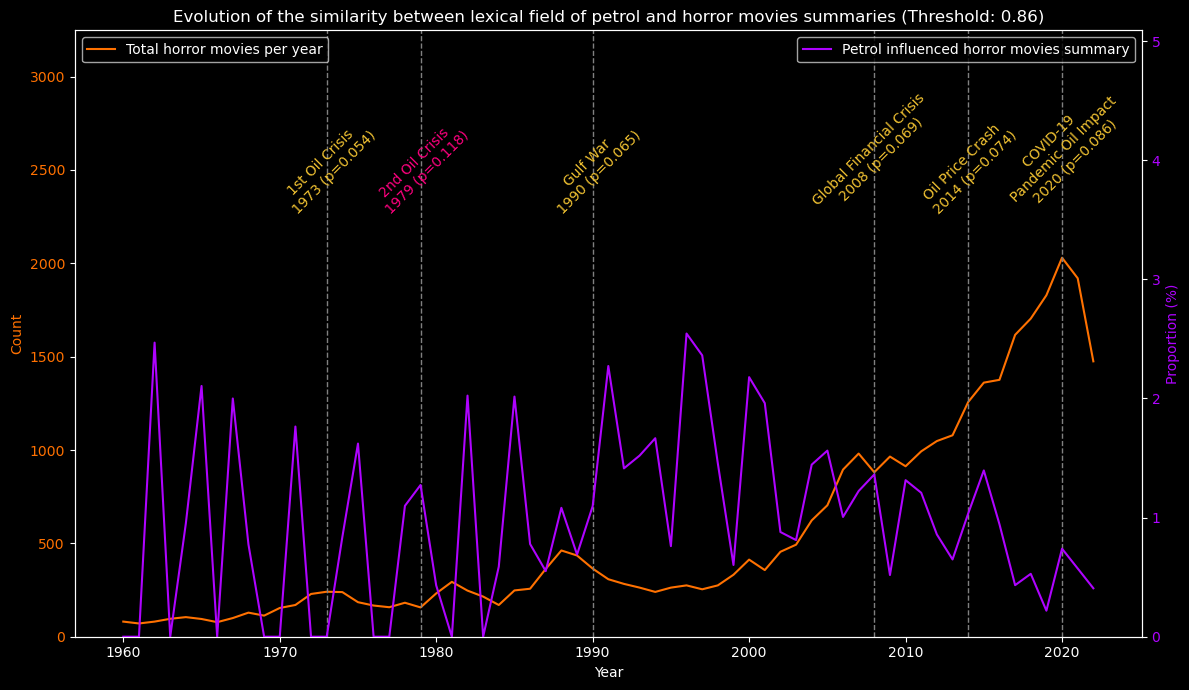

In [98]:
# Significant petrol-related events
petrol_events = {
    1973: "1st Oil Crisis",
    1979: "2nd Oil Crisis",
    1990: "Gulf War",
    2008: "Global Financial Crisis",
    2014: "Oil Price Crash",
    2020: "COVID-19 \n Pandemic Oil Impact"
}

# Call the function
analyze_similarity(df_hist, similarity_col='Petrol_similarity', events=petrol_events, threshold=0.86)


For a threshold of 0.86, the global financial crisis in 2008 is the only event significant at 5%, while there are two events that are significant at 10%: the 1st oil crisis in 1973 and the COVID 19 pandemic impact on oil in 2020. Historically, over the year 2006, 2007 and 2008, the price of a barel increased slowly until reaching a value of the $147 July 2008, before a sharp decrease to reach a value of $32 in December of the same year, as we can see on the plot. It is interesting to note that 2008 is the only period, between 1995 and 2020, which show a decrease in the total number of horror movies. This is also a consequence of the global economic crisis because of declining consumer spending, reduced financing, and changes in audience behavior. Coming back to petrol crisis, in 1973, the Organization of Arab Petroleum Exporting Countries (OAPEC) imposed an embargo on nations supporting Israel during the Yom Kippur War, including the U.S., Japan, and several European countries. In consequence, the price of the barrel rose by 300%. Thus, we can see that the most important petrol crisis had an influence on the words used in  movies horror summaries.

### Communism

In [99]:
# List of keywords related to communism, generated by chat-GPT
communism_keywords = [
    "communism", "equality", "revolution", "proletariat", "collectivism", 
    "socialism", "Marxism", "class", "bourgeoisie", "labor", "solidarity", 
    "state", "redistribution", "ideology", "party", "collective", "worker", "union", 
    "comrade", "land", "people", "reform", "ownership", "struggle", "equality", 
    "freedom", "manifesto", "nation", "policy", "community", "control", "authority", 
    "dictatorship", "plan", "economy", "utopia", "power", "rights", "progress", 
    "system", "justice", "common"
]

# Generate subject vector
communism_vector = get_average_vector(communism_keywords, model)

# Apply similarity check to each summary
df_hist['Communism_similarity'] = df_hist['Summary'].apply(lambda x: calculate_similarity(x, communism_vector, model))

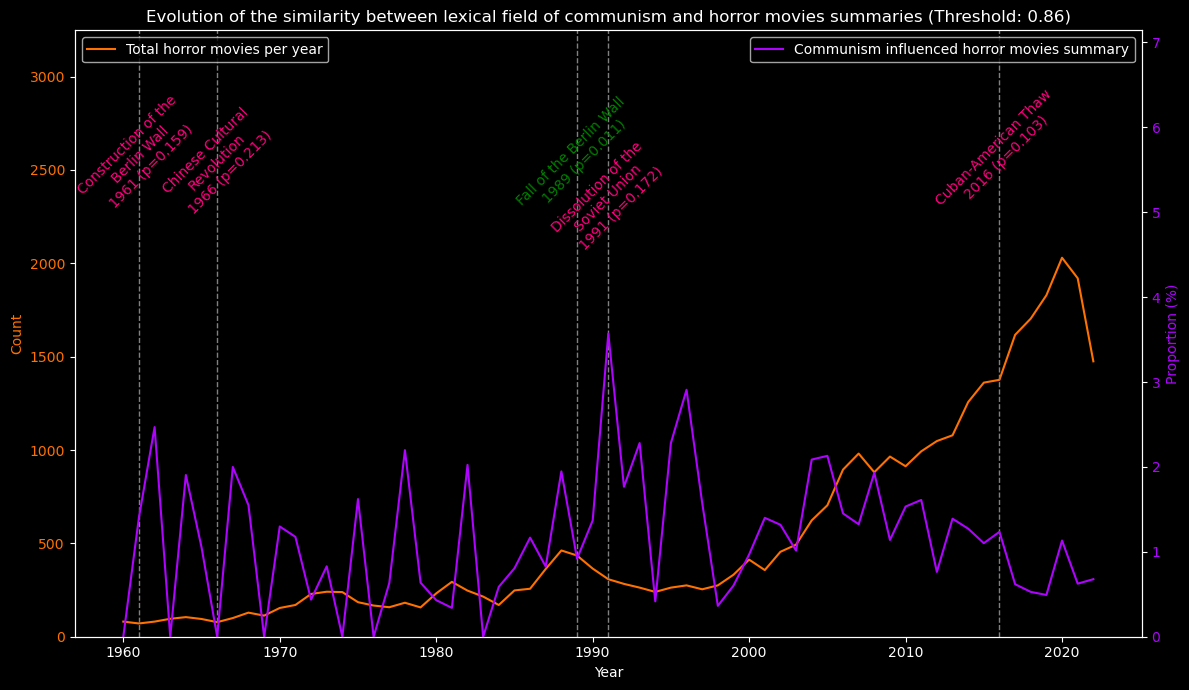

In [100]:
# Historical communism events determined with chat-GPT
communism_events = {
    1961: "Construction of the\n Berlin Wall",
    1966: "Chinese Cultural\nRevolution",
    1989: "Fall of the Berlin Wall",
    1991: "Dissolution of the\nSoviet Union",
    2016: "Cuban-American Thaw"
}

# Call the function
analyze_similarity(df_hist, similarity_col='Communism_similarity', events=communism_events, threshold=0.86)

For a threshold equal to 0.86, the fall of the Berlin wall in 1989 is the most significant event, with the highest peak over the entire time period, appearing two years after. This corresponds quite well to the minimum time before the release of a movie after some event that is not a sudden change (like crisis or terrorist attacks). Here we can see that the most symbolic communist related events of the last 60 years has a direct influence on the lexical fields used to describe the summary of horror movies at this period. The Cuban American Thaw also shows a significant p_value at 10% which is represented by a decrease in the proportion of movie summary related to communism that we would have expected due to the normalization of the Cuban American relation. Overall, we can observe that since the maximum peak in 1991, consequence of the fall of Berlin wall, the proportion of horror movies that show similarity with the communism lexical field has decrease slowly, proof of the end of the fear of communism in a capitalistic world.

### Nuclear

In [101]:
# List of keywords related to nuclear, generated by chat-GPT
nuclear_keywords = [
    "nuclear", "radiation", "disaster", "meltdown", "reactor", "Chernobyl", 
    "Fukushima", "atomic", "fallout", "radioactive", "contamination", 
    "nucleon", "plume", "nucleus", "radiological", "uranium", "plutonium", 
    "exposure", "radiation", "hazard", "energy", "core", "criticality", "waste", 
    "mutation", "reactivity", "isotope", "fusion", "bomb", "energy", "heat", 
    "spill", "hazardous", "radiotherapy", "pollution", "emergency", "radiation", 
    "safety", "risk", "breach", "accident", "fallout", "toxic"                  
]

# Generate subject vector
nuclear_vector = get_average_vector(nuclear_keywords, model)

# Apply similarity check to each summary
df_hist['Nuclear_similarity'] = df_hist['Summary'].apply(lambda x: calculate_similarity(x, nuclear_vector, model))

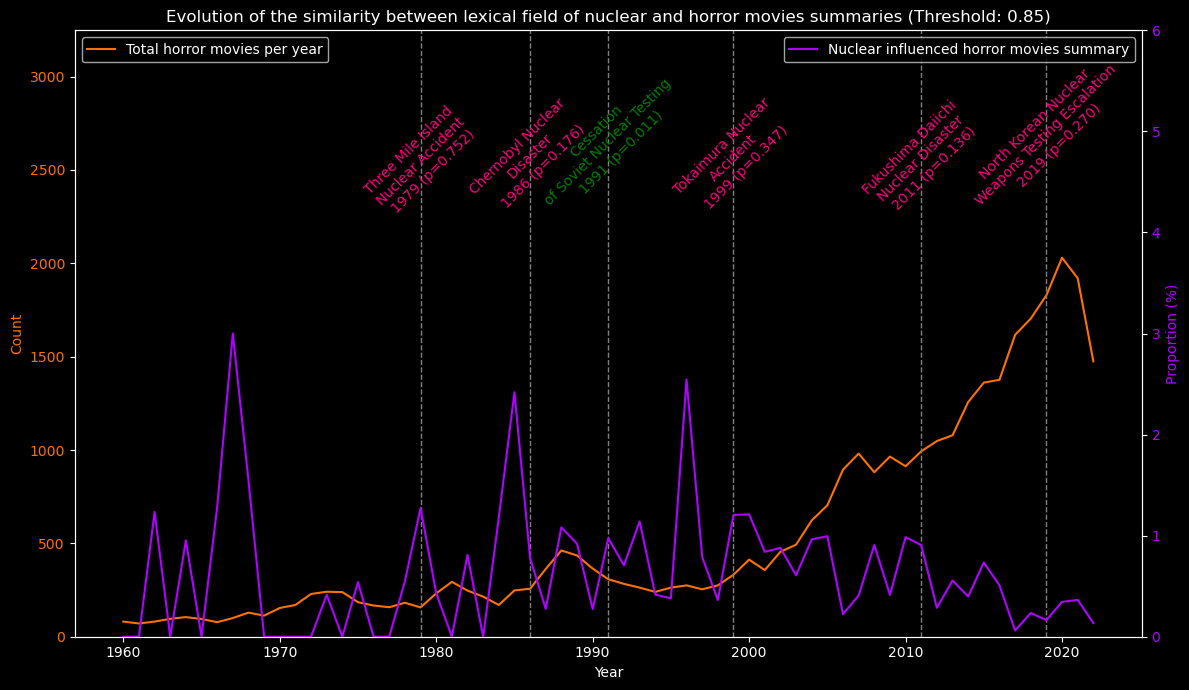

In [102]:
# Historical nuclear events determined with Chat-GPT
nuclear_events = {
    1979: "Three Mile Island\nNuclear Accident",
    1986: "Chernobyl Nuclear \nDisaster",
    1991: "Cessation\nof Soviet Nuclear Testing",
    1999: "Tokaimura Nuclear\nAccident",
    2011: "Fukushima Daiichi\nNuclear Disaster",
    2019: "North Korean Nuclear\nWeapons Testing Escalation",
    }

# Call the function
analyze_similarity(df_hist, similarity_col='Nuclear_similarity', events=nuclear_events, threshold=0.85)

For a threshold of 0.85, it seems like xe have three significant events: the Chernobyl nuclear disaster in 1986, the cessation of soviet testing in 1991 and the Fukushima Daiichi nuclear disaster in 2011. Nevertheless, the test in 1986 and 2011 are based on a decrease in the proportion of movies summaries influenced by the subject which is not really coherent with the real events, which we would expect to show an increase. We would not have expected the cessation of soviet testing to be significative since it is not a very outsanding event in our mind. We should not forget that the major number of movies are produced in the United States of America which are directly impacted by the end of the soviet union and this cessation, thus explained this peak.

## Limits of the historical analysis

We have found ourselves limited by the fact that we have to choose the threshold of acceptability of a movie summary in a topic. A low threshold introduces a high number of movies that are not really related to the lexical field of the topic, whereas a high threshold restrains the number of movies that are not really related to the lexical field of the topic but implies not considering the influence of less famous historical events. 

We have tried not using a threshold and using the mean cosine similarity per year directly ofr the statistical test. Accounting the fact that each year there are only a few movies that are related to the lexical field of a subject, a problem arised from the use of the mean value per year. Indeed, whatever the subject studied, the evolution of the mean cosine similarity per year was very similar. The high values of cosine similarity at some dates are diluted among all the other values so have not such an important influence.

The other problem that was encontered was the choice of range of research for a minimum and a maximum proportion of movie influenced by a topic. If we take a large range, the probability a introducing an error in very high but if we take a too short range, we will miss a potential change and lose the significance. I would have been interesting to introduce a range that changes for each type of event. For a punctual and shocking event (like crisis), we choose a small searching range whereas for an event spread over time (like cold war), we choose a larger searching range. 

We should take into account the fact that we neglected the presence of noise during our interpretation. For example, on the flu topic, it might be possible that the HIV/AIDS virus, which is still spreading, affects the results of the test that we run on specific historical events. 